In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import simpson

## MEAN FIELD METHOD

In this relation we want to compute some ground state properties of a system of N particles described by the generic Hamiltonian:
$$
\hat{H} = \sum_{i=1}^{N} \left( \frac{-\hbar^2}{2m} \nabla^2_i + V_{\text{ext}}(\mathbf{r}_i) \right) + \frac{1}{2} \sum_{i\neq j} v(\mathbf{r}_i, \mathbf{r}_j)
$$
where $\vec{r}_1 ... \vec{r}_N$ are the coordinates of our N particles, $V_{ext}=\frac{1}{2}m\omega^2r^2$ is an harmonic external field and $v$ is the interaction potential which we suppose being
$$
v\left( \mathbf{r}, \mathbf{r'} \right) = 4\pi \frac{\hbar^2}{m} a  \delta(\mathbf{r} - \mathbf{r'})
$$
In the mean field approximation we assume that the wave function can be written as a product of single particle functions:
$$
\Psi(\mathbf{r}_1 \dots \mathbf{r}_N) = \hat{P}_{s,a} \phi_1(\mathbf{r}_1) \phi_2(\mathbf{r}_2) \dots \phi_N(\mathbf{r}_N)   \quad\quad\quad  \phi(\mathbf{r})=\frac{\phi(r)}{r}\frac{1}{\sqrt{4 \pi}}
$$
and since we want to model a boson system the permutation operator has the form
$$
\hat{P}_s = \frac{1}{\sqrt{N!}} \sum_{\hat{P}} \hat{P}
$$
To minimize the expectation value we use the variational method which, with the assumption of single particle wave function normalize to 1, leads to the Gross-Pitaevskij equation (GP):
$$
-\dfrac{1}{2}\dfrac{d^2}{dr^2}\phi(r)+\dfrac{1}{2}r^2\phi(r)-\dfrac{1}{2}\dfrac{\ell(\ell+1)}{r^2}\phi(r)+Na\left(\dfrac{\phi(r)}{r}\right)^2\phi(r)=\mu\phi(r)
$$
where energies are expressed in units of $\hbar\omega$ and lengths are expressed in units of the harmonic oscillator length $a_{ho}=\sqrt{\frac{\hbar}{m\omega}}$. $\phi(r)$ is the radial solution of the signle particle wave function.
Since we are interested in the energy of the ground state we assume the particles in the s-wave state only (l=0) so that we have to solve
$$
-\dfrac{1}{2}\dfrac{d^2}{dr^2}\phi(r)+\dfrac{1}{2}r^2\phi(r)+Na\left(\dfrac{\phi(r)}{r}\right)^2\phi(r)=\mu\phi(r)
$$
By defyning $k^2=2\mu-r^2-2Na\left(\dfrac{\phi(r)}{r}\right)^2$ we can recast the last equation as
$$
\dfrac{d^2}{dr^2}\phi(r)+k^2 \phi(r)=0
$$
which can be solved using Numerov algorithm.

# Numerov algorithm and matching

In [2]:
# Numerov algorithm
def numerov(psi_p, psi_c, i, k, h):
    '''Input: previous wavefunction value psi_p, current wavefunction value psi_c, index, K array, step size h'''
    psi_next = (-psi_p*(1+h**2/12*k[i-1])+2*psi_c*(1-(5*h**2)/12*k[i]))/((1+h**2/12*k[i+1]))
    return psi_next


In [3]:
#wavwfunction normalization
def normalization(psi, h):
    '''Input: wavefunction psi, step size h''' 
    psi_squared_integrated = np.sum(np.abs(psi)**2) * h # integrate |psi|^2 over the range
    normalization_constant = 1/np.sqrt(psi_squared_integrated) # normalization factor
    return np.array(psi)*normalization_constant # normalized wavefunction

For computational stability we decide to implement Numerov's algorithm only for $R(r)^{n\ell}$ (in the previous paragraph $\phi(r)$), the radial part of the wavefunction 
$$
\psi(r, \theta, \phi) = \frac{R(r)^{n\ell}}{r} Y_{\ell m}(\theta,\phi)
$$
When the total wavefunction is required we will simpli divide by $r$

In [4]:
# Finding the solution forward
def forward_solution(r,E,N,v,h):
  '''Input: r array, energy E, number of points N, potential v array, step size h'''
  #energy E is a scalar
  phi=[]
  phi.append(0)
  phi.append(h)

  K=[]
  for j in range(N):
    K.append(2*E-r[j]**2-v[j])

  for i in range(1,N-1,1):
    phi.append(numerov(phi[i-1],phi[i],i,K,h))

  return phi

#Findind the solution backward
def backward_solution(r,E,N,v,h):
  '''Input: r array, energy E, number of points N, potential v array, step size h'''
  #energy E is a scalar
  
  #To find the solution backward, we need to reverse the order of the r and psi arrays to use the Numerov algorithm
  r = r[::-1]
  phi_=[]

  phi=[] #initializing the tail
  phi.append(math.exp(-0.5*(r[0])**2))
  phi.append(math.exp(-0.5*(r[1])**2))

  K=[]
  for j in range(N):
    K.append(2*E-r[j]**2-v[j])

  for i in range(1,N-1,1):
    phi.append(numerov(phi[i-1],phi[i],i,K,h))

  phi_.append(phi[::-1])
  return phi_

In [5]:
# Testing the Numerov algorithm
N = 5000
L = 5
h = L/N

E = 1.5 # forward_solution and backward_solution read energy as a scalar
Na = 0

r = np.linspace(0.0001, L, N) # r values from 0 to L with N points

v = []
psi = np.zeros(N) # initialize the wavefunction array
for j in range(N):
    v.append(2*Na*(psi[j]**2/r[j]**2))

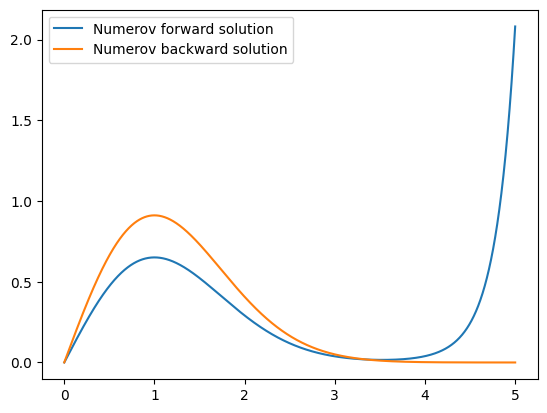

In [6]:
plt.plot(r,normalization(forward_solution(r,E,N,v,h),h),label='Numerov forward solution')
plt.plot(r,normalization(backward_solution(r,E,N,v,h)[0],h),label='Numerov backward solution')
plt.legend()

We do see how the how the solution obtained with the forward procedure diverges, a matching is required.
We choose the classical inversion point for an harmonic potential which is the coordinate that satisfy $V(r)=E$. It can be proven that we are in a zone where the solution is smooth with no nodes.

In [7]:
def index_inversion_point(r,r_inversion):
    '''Input: r array, inversion point r_inversion'''
    difference = np.abs(r - r_inversion)
    index = np.argmin(difference)
    return index
    
def log_der(left_psi,right_psi,index):
    '''Input: left wavefunction, right wavefunction, index of the inversion point'''
    left_der = np.gradient(left_psi,h)[index]
    right_der = np.gradient(right_psi,h)[index]
    value = left_der / left_psi[index] - right_der / right_psi[index]
    return value    

In [8]:
def matching(E, r, N, v, h):  
    '''Input: energy E, r array, initial wavefunction phi_guess, number of points N, Na, step size h'''
    #here the energy has to be an array!
    
    xi = [] #here we save the mismatch values
    phi_normalized = [] #here we save the normalized wavefunctions

    for x in range(len(E)): #for each energy we calculate the matching

        energy = E[x] #savign the value of the energy
        r_k = np.sqrt(2*energy) #ideal inversion point

        left_phi = forward_solution(r,energy,N,v,h)
        right_phi = backward_solution(r,energy,N,v,h)[0]
        index = index_inversion_point(r,r_k)
        value = log_der(left_phi,right_phi,index)
        xi.append(value)

        #ratio of the wavefunctions at the inversion point to match amplitudes
        ratio = left_phi[index] / right_phi[index] 
        
        #wavefunction might have different signs 
        if left_phi[index] / right_phi[index] < 0: 
            ratio = -ratio
            right_phi = ratio * np.array(right_phi)
        else:
            right_phi = ratio * np.array(right_phi)

        #matching the wavefunctions
        phi= []
        phi.append(left_phi[:index])
        phi.append(right_phi[index:])
        phi = np.concatenate(phi)

        phi_normalized = normalization(phi, h)


    return phi_normalized , xi

In [27]:
# Testing the Numerov algorithm with longer radius
N = 1000
L = 10
h = L/N

E = [1.5]
Na = 0

r = np.linspace(0.0000001, L, N) # r values from 0 to L with N points

v = []
phi = np.zeros(N) # initialize the wavefunction array
for j in range(N):
    v.append(2*Na*(phi[j]**2/r[j]**2))

Normalization of the wavefunction:  0.9999999999999994


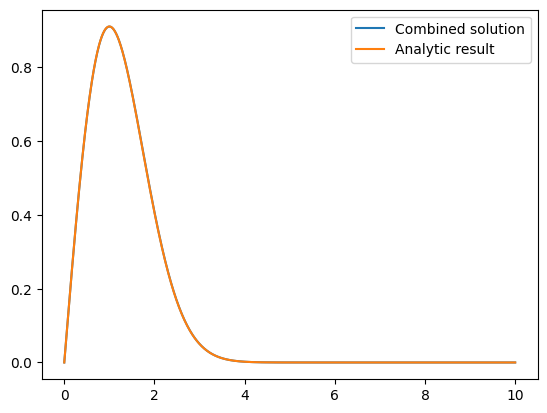

In [28]:
plt.plot(r,matching(E, r, N,  v, h)[0],label='Combined solution')
plt.plot(r,np.pi**(-0.25)*np.exp(-0.5*np.array(r)**2)*2*np.array(r),label='Analytic result')
plt.legend()
print("Normalization of the wavefunction: ", sum(np.abs(matching(E, r, N, v, h)[0])**2 * h))

# Solving GP 
We can now proceed to find the ground state of a gas of cold atoms (ℓ=0) 

In [29]:
def GP(E,r,N,v,h):
    '''Input: E = array of trial energies'''
    eigenvalue = []
    eigenfunction = []

    xi= matching(E, r, N,  v, h)[1]

    eigenvalue = []
    eigenfunction = []

    count = 0
    for i in range(len(E) - 1):
        if count > 0:
            break
        if xi[i] * xi[i+1] < 0:
            # Zone where the sign changes, we restrict the interval
            energies = np.linspace(E[i],E[i+1],100)
            # New finer matching in the restricted interval
            finer_xi = matching(E, r, N, v, h)[1]

            for j in range(1,len(energies)):
                if finer_xi[j-1] * finer_xi[j] < 0:
                    eigenvalue.append(energies[j])
                    eigenfunction.append(matching([energies[j-1]], r, N,  v, h)[0])
                    #energies[j] is in square bracketrs beacuse matching function needs array
                    count += 1
                    break  

    return eigenvalue, eigenfunction

In [30]:
E = np.linspace(0.1, 5, 100)

eigenvalue, eigenfunction = GP(E,r,N,v,h)

In [31]:
print(f"Eigenvalue: {float(eigenvalue[0]):.10f}")

Eigenvalue: 1.5003571064


Text(0.5, 1.0, 'Harmonic Oscillator ground state wavefunction')

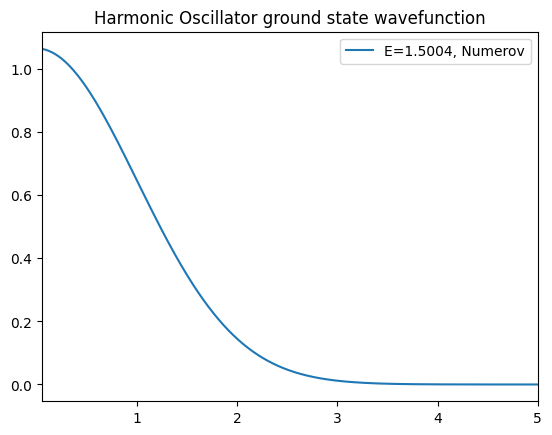

In [32]:
plt.plot(r,normalization(eigenfunction[0]/r,h),label=f"E={float(eigenvalue[0]):.4f}, Numerov") #still normalized??
plt.xlim(0.05,5)
plt.legend()
plt.title('Harmonic Oscillator ground state wavefunction')

We plot now the density of the system for $N_A$ particles

In [33]:
N_A = 6.02214076e23

rho = N_A * eigenfunction[0]**2 / np.array(r)**2

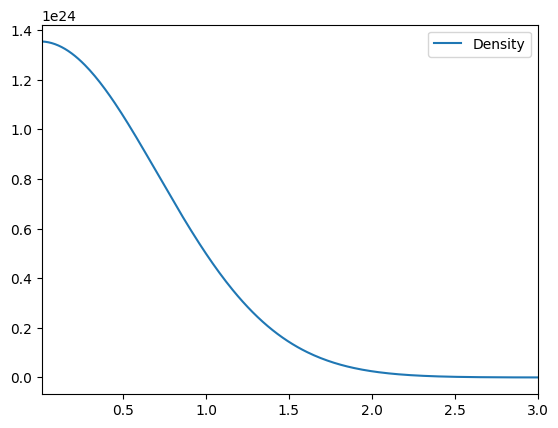

In [34]:
plt.plot(r,rho,label='Density')
plt.xlim(0.01,3)
plt.legend()

## Flowchart for the self-consistent solution of the mean field equations (both GP and HF)

1) Guess initial reasonable function $\phi$
2) Evaluate the effective potential $v$ ,which contains both the terms $V_{ext}(\vec{r})$ and $v(\vec{r},\vec{r}')$, and if this is not the first step combine it with the one of th eprevious iteration as $v_{new}=\alpha v_{new}+(1-\alpha)v_{old}$
3) Solve HF-GP and get a $\phi_{new}$ to calculate the energy
4) If the energy satisfy convergence criteria stop, otherwise go back to 2. and solve the potential with $\phi_{new}$ to get a new effective potential $v_{new}$

Since now we are goign to set $Na\neq 0$ another term will enter the potential and phi_guess starts to be fundamental.
To test the convergence we choose a threshold $\epsilon = 0.0001$, thus the self-consistent iteration will proceed until $\Delta E < \epsilon$.
We need now to discuss how to evaluate the energy at each step. There are two possible ways.

The first way to evaluating the energy is through the evaluation of the energy functional:
$$ \frac{E[\phi]}{N}=-\dfrac{1}{2}∫ ϕ(r)\left(\dfrac{d^2}{dr^2}\phi(r)\right) dr + \dfrac{1}{2}∫|ϕ(r)|^2 r^2 dr+ \dfrac{1}{2}Na\int|\phi(r)|^2\left(\dfrac{\phi(r)}{r}\right)^2 dr
$$

The second one comes from the meaning of the eigenvalue $\mu$, thus:
$$\frac{E_{\mu}}{N}=\mu-E_{int}=\mu-\dfrac{1}{2}Na\int_0^{\infty}|\phi(r)|^2\left(\dfrac{\phi(r)}{r}\right)^2\,dr\,.$$
where $\phi$ is the radial part of the wavefunction, obtained in the solution of the GP equation.

In [35]:
def total_energy(r,psi,h):
    A = np.array(psi)  
    r = np.array(r) 

    #first and second derivatives
    A_prime = np.gradient(A, h)
    A_second = np.gradient(A_prime, h)

    #calculating the functionqal energy
    functional_energy = -0.5*simpson(A*A_second,r,dx=h) + 0.5*simpson(A**2*r**2,r,dx=h) + 0.5*Na*simpson(A**4/r**2,r,dx=h)

    return functional_energy

total_energy_eval = total_energy(r,eigenfunction[0],h)
print(f"Total energy: {total_energy_eval:.10f}")

Total energy: 1.5029463437


In [36]:
def total_energy_mu(r,psi,h,eigenvalue):
    A = np.array(psi)  
    r = np.array(r) 

    total_energy = eigenvalue -  0.5*Na*simpson(A**4/r**2,r,dx=h)

    return total_energy

total_energy1 = total_energy_mu(r,eigenfunction[0],h,eigenvalue[0])
print(f"Total energy: {total_energy1}")


Total energy: 1.5003571064177128


In [19]:
Na = 100
alpha = 0.001

In [37]:
N = 1000
L = 10
h = L/N

r = np.linspace(0.0000001, L, N) # r values from 0 to L with N points

In [38]:
def interaction(r,phi,Na):
    return (2*Na*(np.array(phi)**2/np.array(r)**2))

def mixing(v_old,v_new,alpha):
    v_old = np.array(v_old)
    v_new = np.array(v_new)
    return alpha*v_new + (1-alpha)*v_old

In [39]:
DeltaEnergy = 10
DeltaEnergyPrevious = 10
threshold = 0.1

E = np.linspace(1,10,100)
eigenvalues = []
eigenfunctions =[]

phi_old = eigenfunction[0]
phi_new = []


v = interaction(r,phi_old,Na) #potential for the first iteration  

eigenvalues.append(eigenvalue[0]) #defining the first energy of the system

count = 1 #keep track of the eigenvalues to determine DeltaEnergy

while DeltaEnergy > threshold or np.abs(DeltaEnergy-DeltaEnergyPrevious) > threshold:

    eigenvalues.append(GP(E,r,N,v,h)[0][0])
    phi_new = (GP(E,r,N,v,h))[1]
    phi_new = phi_new[0]
    
    v_old = interaction(r,phi_old,Na)
    v_new = interaction(r,phi_new,Na)

    v = mixing(v_old,v_new,alpha)

    phi_old = np.array(phi_new)

    DeltaEnergy = np.abs(eigenvalues[count] - eigenvalues[count-1])

    DeltaEnergyPrevious = np.abs(eigenvalues[count-1] - eigenvalues[count-2])

    print(eigenvalues[count],DeltaEnergy)

    count += 1



1.4600550964187329 0.040302009998979926


In [49]:
DeltaEnergy = 10
DeltaEnergyPrevious = 10
threshold = 0.2
alpha = 0.001

E = np.linspace(1,10,100)
eigenfunctions =[]
energy = []
energy_mu = []

phi_old = eigenfunction[0]
phi_new = []
Na = 100
v = interaction(r,phi_old,Na) #potential for the first iteration  
 
#evaluatong the energy
energy.append(total_energy(r,eigenfunction[0],h))
energy_mu.append(total_energy_mu(r,eigenfunction[0],h,eigenvalue))

count = 1 #keep track of the eigenvalues to determine DeltaEnergy

while DeltaEnergy > threshold or np.abs(DeltaEnergy-DeltaEnergyPrevious) > threshold:

    phi_new = GP(E,r,N,v,h)[1][0]
    eigenvalue = GP(E,r,N,v,h)[0]

    v_old = interaction(r,phi_old,Na)
    v_new = interaction(r,phi_new,Na)

    v = mixing(v_old,v_new,alpha)

    energy.append(total_energy(r,phi_new,h))
    energy_mu.append(total_energy_mu(r,phi_new,h,eigenvalue))

    #DeltaEnergy = np.abs(energy[count] - energy[count-1])
    DeltaEnergy = np.abs(energy[count] - energy_mu[count])
    DeltaEnergyPrevoius = np.abs(energy[count-1] - energy_mu[count-1])

    #DeltaEnergyPrevious = np.abs(energy[count-1] - energy[count-2])

    #print(eigenvalues[count],DeltaEnergy)     functional_energy[count]

    print(energy[count],DeltaEnergy) 
    
    phi_old = np.array(phi_new)
    count += 1

9.59806841981457 [9.37941562]
